### Simple functions to shpere difference correction
This notebook shows how do one correct shpere difference use the following functions:

1. linear: $ A = A_0 * Ct$
2. Power: $ A = A_0 t^{C}$
3. Exp: $ A = A_0 *e^{\alpha t}$

In [1]:
import os
import sys
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, hilbert 

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files, KNNIndex)
plt.style.use('ggplot')
path_raw = '/Users/anton/work/geolog/raw_data/2_Egor_TAR/P00_raw.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw))
field_index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
2020,285,549,1,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,286,-555,2,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,284,564,3,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,287,-583,4,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,283,600,5,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...


In [2]:
batch = (Dataset(field_index, SeismicBatch).next_batch(500)
         .load(fmt='segy', components='raw', tslice=slice(3000))
)

### one trace

In [98]:
def draw_gain(sample, window, xbounds=None, ybounds=None):
    if isinstance(sample, (tuple, list)):
        sample = np.array(sample)
    if len(sample.shape) == 1:
        sample = sample.reshape(1, -1)
    results = []
    for trace in sample:
        H = hilbert(trace).real
        env = (trace**2 + H**2)**.5
        max_val = np.max(env)
        env = (-1) * (max_val / env)
        filtered = medfilt(env, window)
        results.append(filtered)

    result = np.mean(results, axis=0)
    if xbounds is None:
        xbounds = (min(result)-min(result)*1.1, max(result)+min(result)*1.1)
    elif not isinstance(xbounds, (list, tuple, np.ndarray)) or len(xbounds) != 2:
        raise ValueError('xbounds should be list/tuple or numpy array with lenght 2, not {} with lenght {}'.format(type(xbounds), len(xbounds)))
        
    if ybounds is None:
        ybounds = (len(result)+100, -100)
    elif not isinstance(ybounds, (list, tuple, np.ndarray)) or len(ybounds) != 2:
        raise ValueError('ybounds should be list/tuple or numpy array with lenght 2, not {} with lenght {}'.format(type(xbounds), len(xbounds)))

    plt.figure(figsize=(10, 8))
    plt.plot(result, range(len(result)))
    plt.title('Amplitude gain')
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    plt.xlabel('Maxamp/Amp')
    plt.ylabel('Time')
    plt.show()


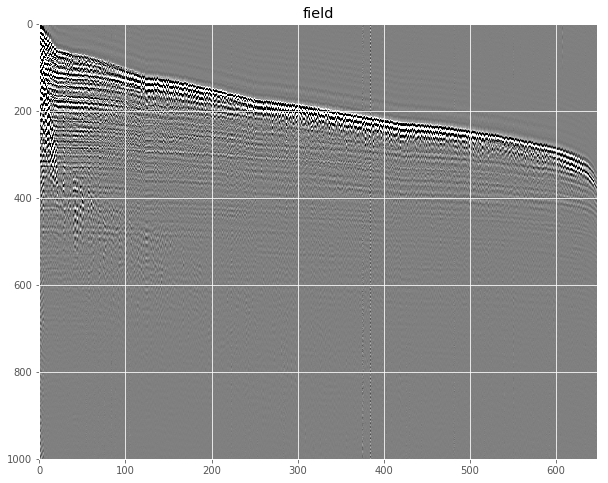

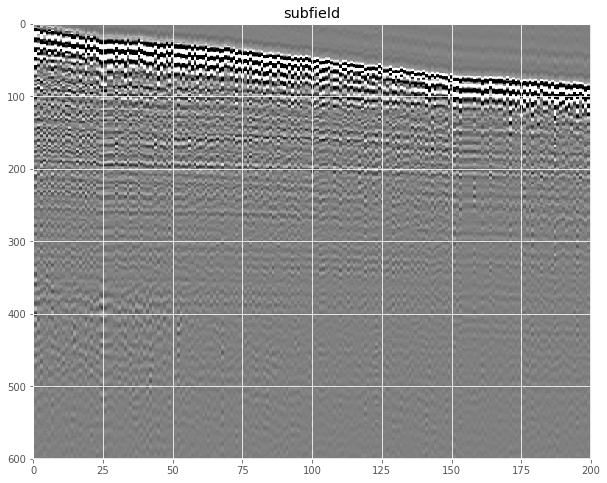

In [43]:
sample = batch.raw[21]
subsample = sample[100:300, 100:700]

seismic_plot(sample*10000, figsize=(10, 8), names='field',
             vmin=-cv, vmax=cv, cmap='gray', )
seismic_plot(subsample*10000, figsize=(10, 8), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')

### area

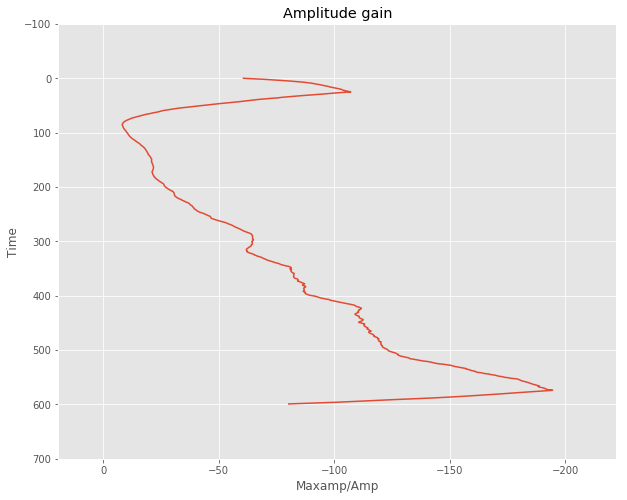

In [105]:
draw_gain(subsample, 51)

### Linear time

In [6]:
def linear_shpere_diff(trace, C):
    t = np.arange(len(trace))
    new_trace = trace * (C * t)
    return new_trace


##### with trace

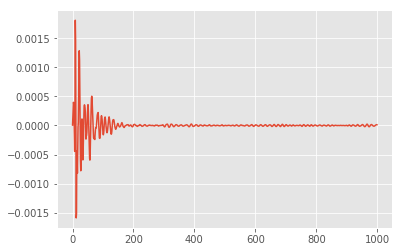

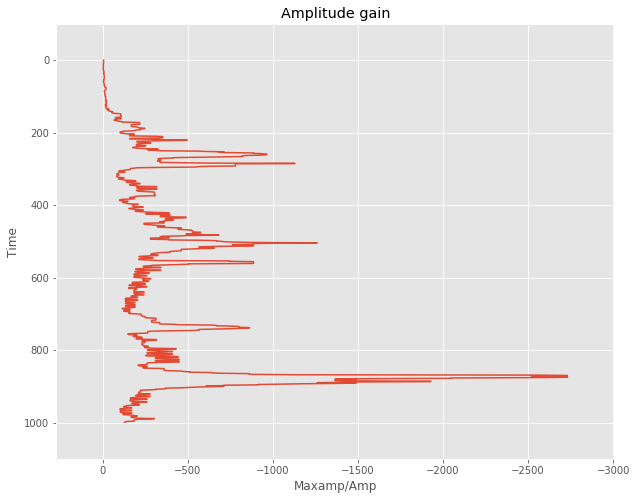

In [44]:
trace = sample[0]
plt.plot(trace)
draw_gain(trace, 11)

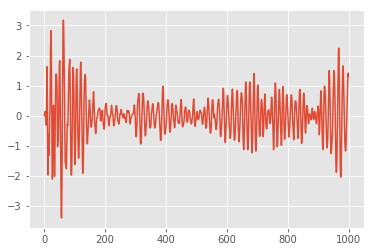

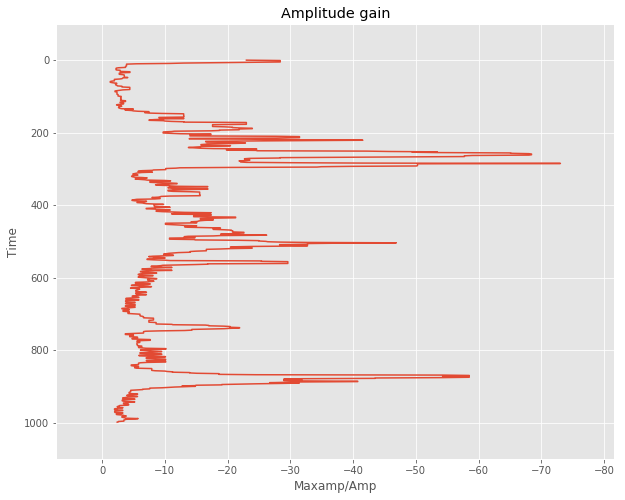

In [45]:
new_trace = linear_shpere_diff(trace, 100)
plt.plot(new_trace)
draw_gain(new_trace, 11)

##### with subfield

In [111]:
new_field = []
for trace in subsample:
    new_field.append(linear_shpere_diff(trace, 100))
new_field = np.array(new_field)

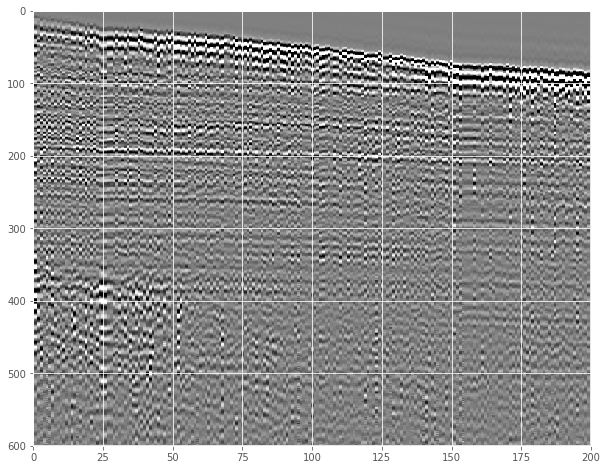

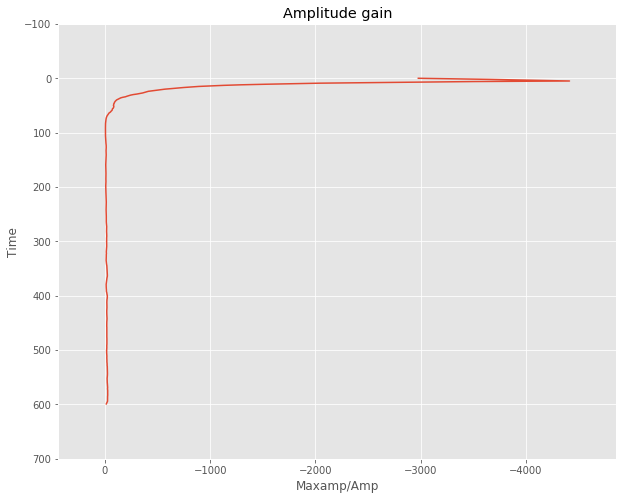

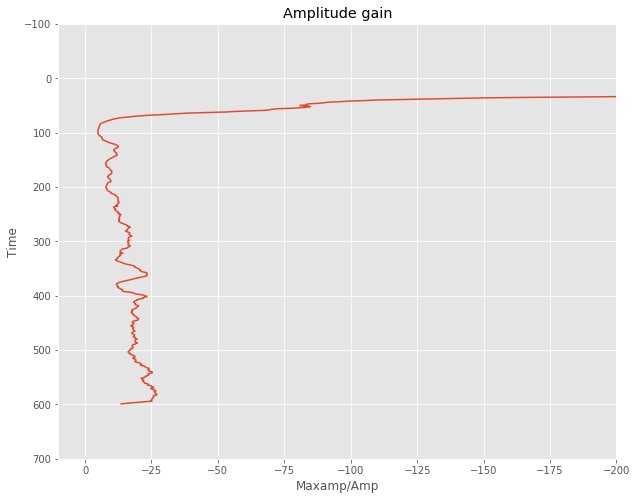

In [113]:
cv = 0.1

seismic_plot(new_field, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[10, -200])

##### with field

In [57]:
new_field = []
for trace in sample:
    new_field.append(linear_shpere_diff(trace, 500))
new_field = np.array(new_field)

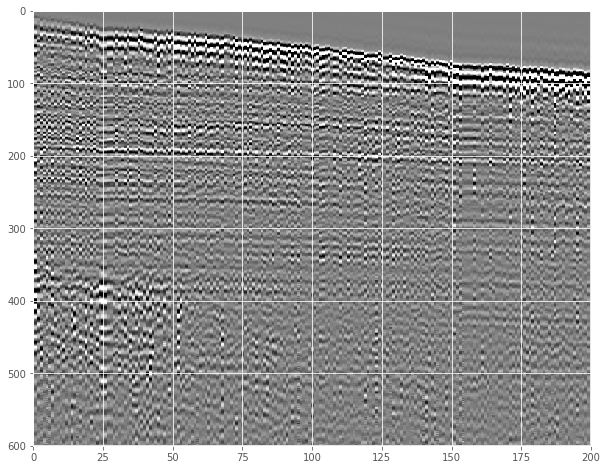

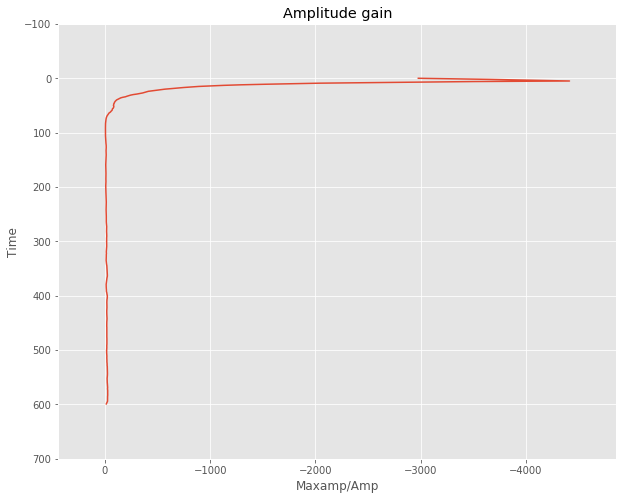

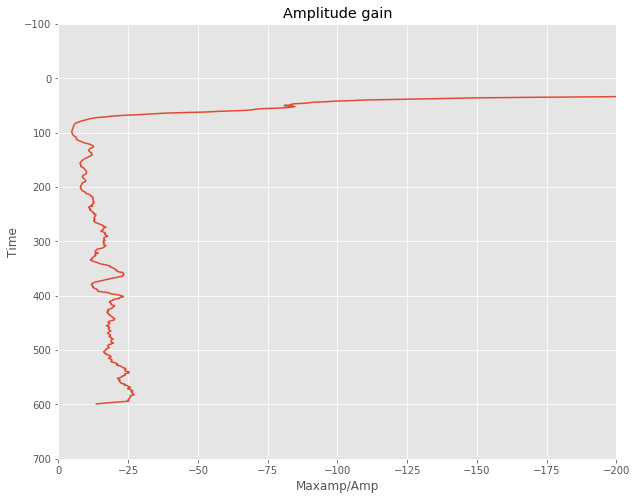

In [114]:
cv = 0.1

seismic_plot(new_field, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[0, -200])

### Power time

In [61]:
def power_shpere_diff(trace, alpha):
    t = np.arange(len(trace))
    new_trace = trace * t**alpha
    return new_trace

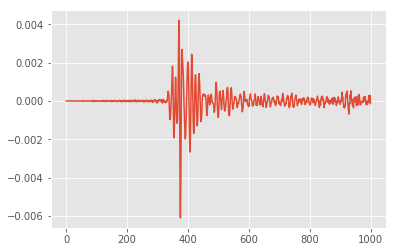

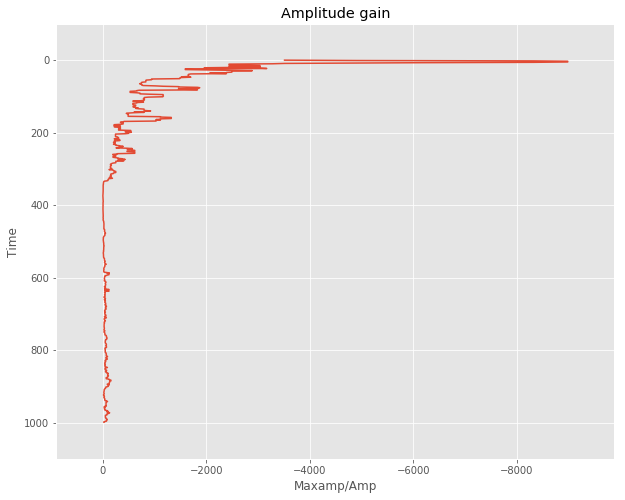

In [108]:
new_trace = linear_shpere_diff(trace, 2)
plt.plot(new_trace)
draw_gain(new_trace, 11, )

##### with subfield

In [120]:
new_field = []
for trace in subsample:
    new_field.append(power_shpere_diff(trace, 2))
new_field = np.array(new_field)

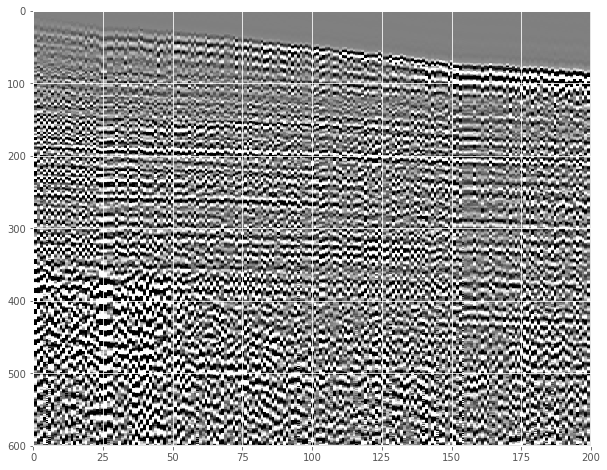

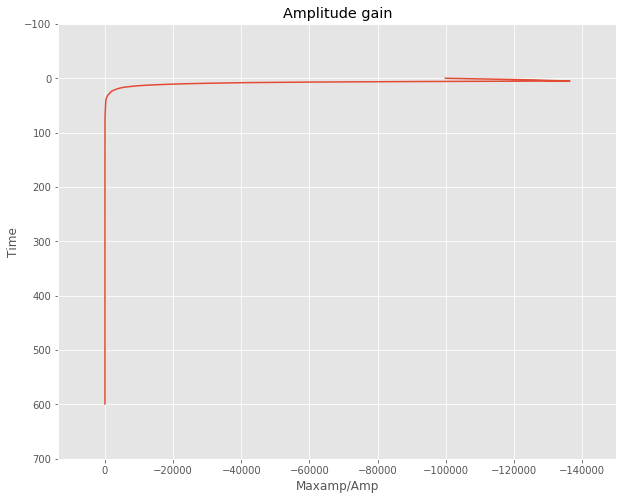

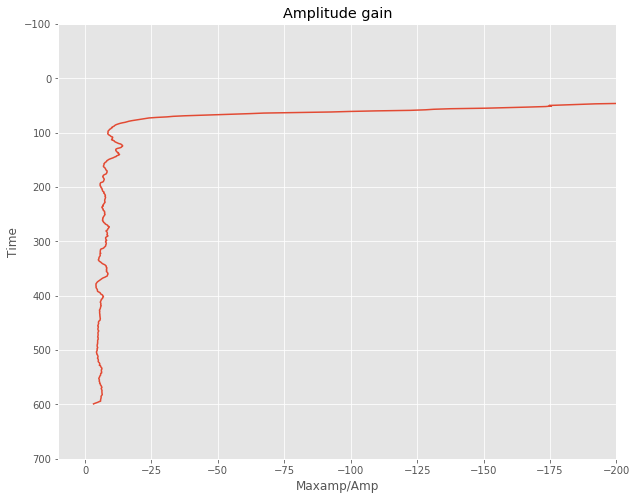

In [121]:
cv = 0.1

seismic_plot(new_field, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[10, -200])

##### with field

In [118]:
new_field = []
for trace in sample:
    new_field.append(linear_shpere_diff(trace, 10))
new_field = np.array(new_field)

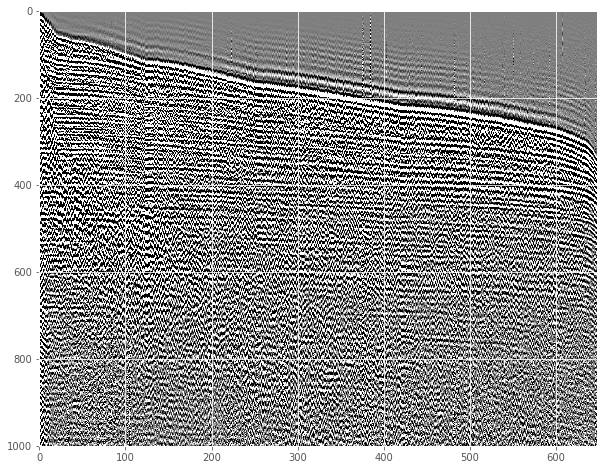

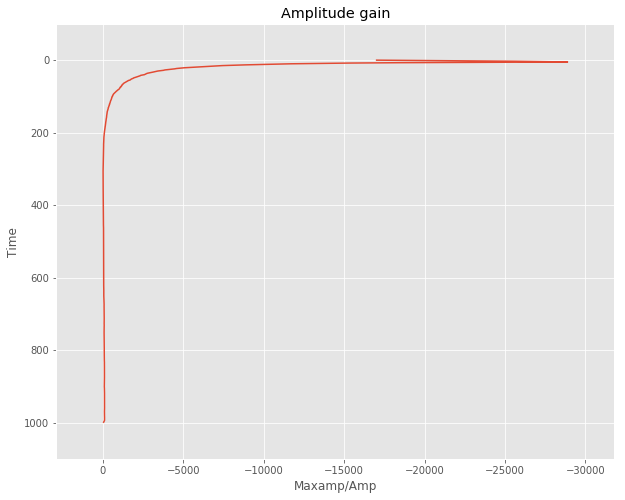

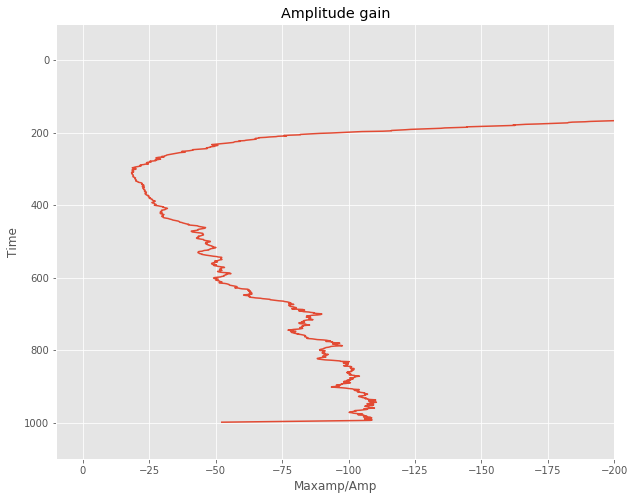

In [119]:
cv = 0.1

seismic_plot(new_field*100, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[10, -200])

### Exponent

In [129]:
def exp_shpere_diff(trace, alpha):
    t = np.arange(len(trace))
    new_trace = trace * np.exp(t*alpha)
    return new_trace

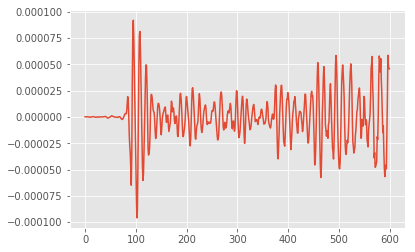

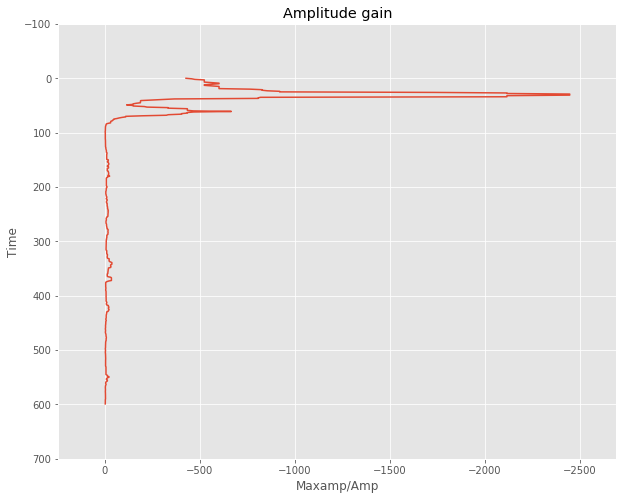

In [143]:
new_trace = exp_shpere_diff(trace, .009)
plt.plot(new_trace)
draw_gain(new_trace, 11, )

##### with subfield

In [169]:
new_field = []
for trace in subsample:
    new_field.append(exp_shpere_diff(trace, .01))
new_field = np.array(new_field)

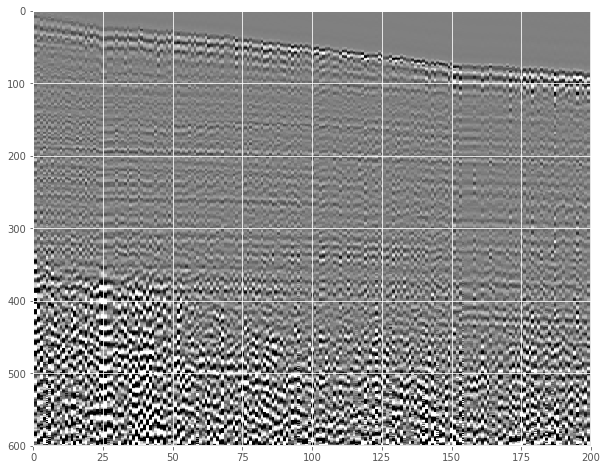

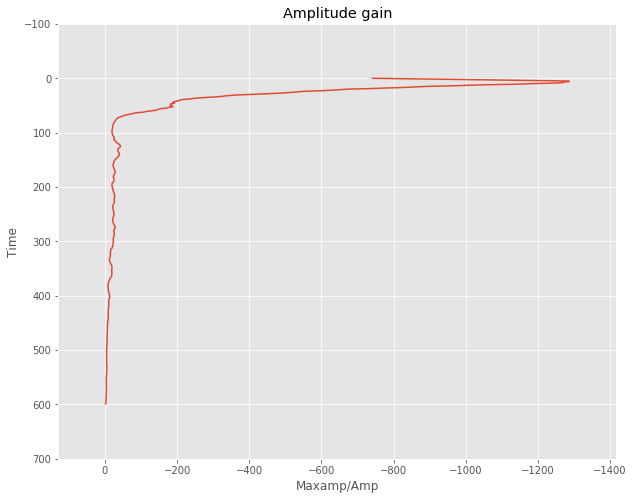

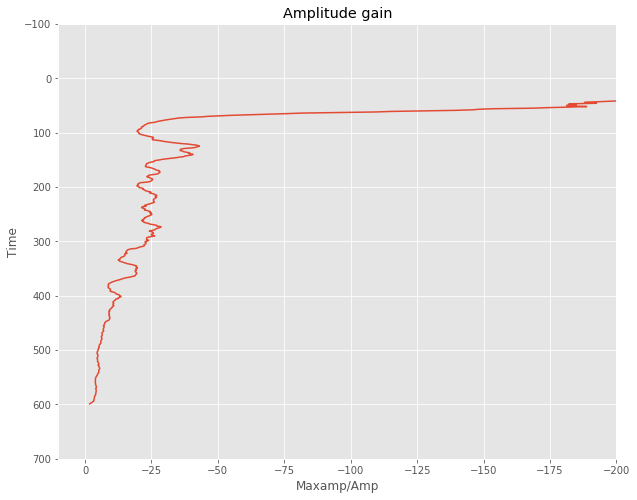

In [170]:
cv = 0.1

seismic_plot(new_field*1000, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[10, -200])

##### with field

In [185]:
new_field = []
for trace in sample:
    new_field.append(exp_shpere_diff(trace, .005))
new_field = np.array(new_field)

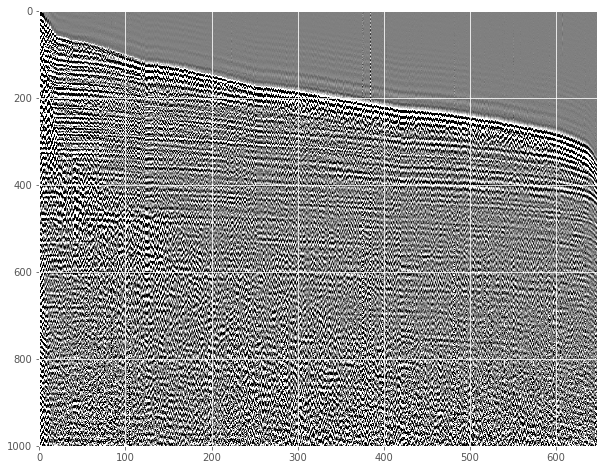

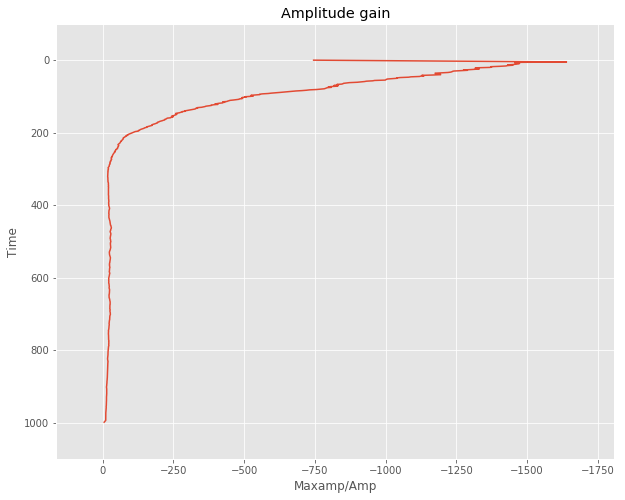

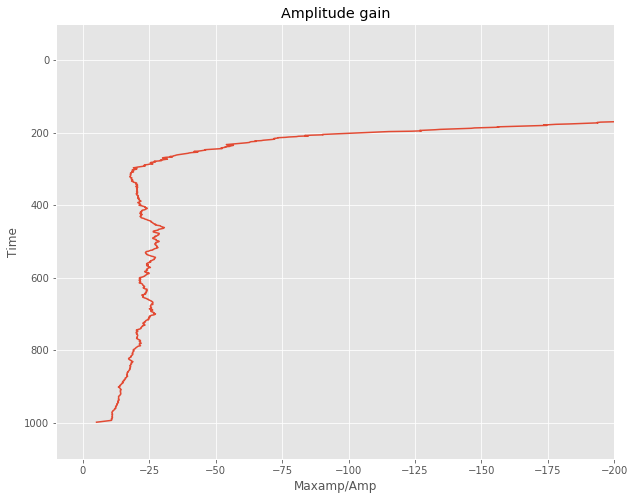

In [189]:
cv = 0.1

seismic_plot(new_field*10000, figsize=(10, 8),
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(new_field, 11)
draw_gain(new_field, 11, xbounds=[10, -200])